In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


### Plot the number of ratings per movie and user

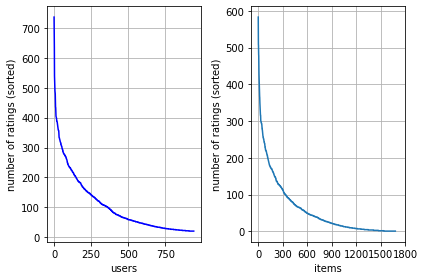

min # of items per user = 20, min # of users per item = 1.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  

    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    
    # build train and test matrix
    train = sp.lil_matrix(valid_ratings.shape)
    test = sp.lil_matrix(valid_ratings.shape)
    
    nonzero_items, _ = valid_ratings.nonzero()
    
    for item in set(nonzero_items):
        _, nonzero_users = valid_ratings[item, :].nonzero()
        # randomly select 10% of nonzero users for a given item
        test_idx = np.random.choice(nonzero_users, size=int(p_test * len(nonzero_users)))
        # the rest of the 90% nonzero users will be in the trian set
        train_idx = list(set(nonzero_users) - set(test_idx))
        train[item, train_idx] = valid_ratings[item, train_idx]
        test[item, test_idx] = valid_ratings[item, test_idx]
    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

/Users/dino/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/dino/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:89055
Total number of nonzero elements in test data:8897


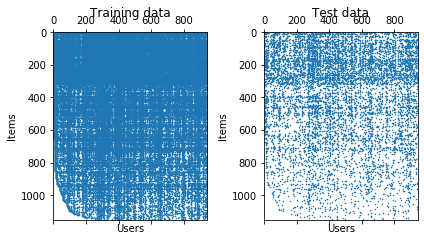

In [5]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [6]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    nonzero_train = train[train.nonzero()]
    global_mean = nonzero_train.mean()
    
    nonzero_test = test[test.nonzero()].todense()
    
    mse = calculate_mse(nonzero_test, global_mean)
    rmse = np.sqrt(mse / test.nnz)
    return rmse

baseline_global_mean(train, test)

matrix([[1.10720389]])

### Use the user means as the prediction

In [7]:
train[:, 0].shape

(1152, 1)

In [8]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    for user_idx in range(num_users):
        train_ratings = train[:, user_idx]
        nonzero_train_ratings = train_ratings[train_ratings.nonzero()]
        # if the user has no rating, skip this user
        if nonzero_train_ratings.shape[0] == 0:
            continue
        else:
            user_means = nonzero_train_ratings.mean()
        
        test_ratings = test[:, user_idx]
        nonzero_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        mse += calculate_mse(nonzero_test_ratings, user_means)
    
    rmse = np.sqrt(mse / test.nnz)
        
    return rmse

baseline_user_mean(train, test)

matrix([[1.03384451]])

### Use the item means as the prediction

In [9]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    for item_idx in range(num_items):
        train_ratings = train[item_idx, :]
        nonzero_train_ratings = train_ratings[train_ratings.nonzero()]
        # if the item has no rating, skip this user
        if nonzero_train_ratings.shape[0] == 0:
            continue
        else:
            item_means = nonzero_train_ratings.mean()
        
        test_ratings = test[item_idx, :]
        nonzero_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        mse += calculate_mse(nonzero_test_ratings, item_means)
    
    rmse = np.sqrt(mse / test.nnz)
    return rmse
    
baseline_item_mean(train, test)

matrix([[1.00701385]])

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [10]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization.
    return:
        user_features: shape = num_features, num_user
        item_features: shape = num_features, num_item
    """
    num_item, num_user = train.shape
    
    user_features = np.random.rand(num_features, num_user)
    item_features = np.random.rand(num_features, num_item)
    
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [11]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # calculate rmse (we only consider nonzero entries.)
    mse = 0
    for row, col in nz:
        user_feature = user_features[:, col]
        item_feature = item_features[:, row]
        prediction = user_feature.T.dot(item_feature)
        mse += (data[row, col] - prediction) ** 2
    rmse = np.sqrt(mse / len(nz))
    return rmse

In [12]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.1
    num_features = 40   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
            # do matrix factorization.
            user_feature = user_features[:, n]
            item_feature = item_features[:, d]
            error = train[d, n] - user_feature.T.dot(item_feature)
            
            user_features[:, n] += gamma * (error * item_feature - lambda_user * user_feature)
            item_features[:, d] += gamma * (error * user_feature - lambda_item * item_feature)
            
        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)

    # evaluate the test error.
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.132446385092593.
iter: 1, RMSE on training set: 1.0963618234913732.
iter: 2, RMSE on training set: 1.0839665694127374.
iter: 3, RMSE on training set: 1.047024744884397.
iter: 4, RMSE on training set: 1.0336640962738923.
iter: 5, RMSE on training set: 1.0093166973850134.
iter: 6, RMSE on training set: 1.0007624160793873.
iter: 7, RMSE on training set: 0.9844462079791279.
iter: 8, RMSE on training set: 0.97430070182983.
iter: 9, RMSE on training set: 0.9681514197671737.
iter: 10, RMSE on training set: 0.9615836814833114.
iter: 11, RMSE on training set: 0.9610240109240931.
iter: 12, RMSE on training set: 0.9560540667331219.
iter: 13, RMSE on training set: 0.952174919113754.
iter: 14, RMSE on training set: 0.9479063151759808.
iter: 15, RMSE on training set: 0.9443404517470848.
iter: 16, RMSE on training set: 0.9449662480242736.
iter: 17, RMSE on training set: 0.9444092517865411.
iter: 18, RMSE on training set: 0.9

### Learn the Matrix Factorization using Alternating Least Squares

In [13]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""
    # update and return user feature.
    num_users = len(nnz_items_per_user)
    num_features = item_features.shape[0]
    lambda_I = lambda_user * sp.eye(num_features)
    updated_user_features = np.zeros((num_features, num_users))
    
    for user, items in nz_user_itemindices:
        W = item_features[:, items]
        RT = W @ train[items, user]
        LT = W @ W.T + nnz_items_per_user[user] * lambda_I
        updated_user_features[:, user] = np.linalg.solve(LT, RT).squeeze()
        
    return updated_user_features

In [14]:
def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""
    # update and return item feature.
    num_items = len(nnz_users_per_item)
    num_features = user_features.shape[0]
    lambda_I = lambda_item * sp.eye(num_features)
    updated_item_features = np.zeros((num_features, num_items))
    
    for item, users in nz_item_userindices:
        Z = user_features[:, users]
        RT = Z @ train[item, users].T
        LT = Z @ Z.T + nnz_users_per_item[item] * lambda_I
        updated_item_features[:, item] = np.linalg.solve(LT, RT).squeeze()
        
    return updated_item_features

In [15]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    it = 1
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user = train.getnnz(axis=0)
    nnz_users_per_item = train.getnnz(axis=1)
    
    # get nonzero train data, user indices of item and item indices of user
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)
    
    print("learn the matrix factorization using ALS...")
    while change > stop_criterion:
        # update user features when fixing item features
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices)
        # update item features when fixing user features
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices)
        
        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        error_list.append(rmse)
        change = np.abs(error_list[-1] - error_list[-2])
        it += 1
        
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    # evaluate the test error.
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
        
ALS(train, test)

learn the matrix factorization using ALS...
iter: 1, RMSE on training set: 1.227316630935286.
iter: 2, RMSE on training set: 1.0681387287641662.
iter: 3, RMSE on training set: 1.0109816068535695.
iter: 4, RMSE on training set: 0.9806108958972868.
iter: 5, RMSE on training set: 0.9625816516180619.
iter: 6, RMSE on training set: 0.9517909440891787.
iter: 7, RMSE on training set: 0.9452475022348225.
iter: 8, RMSE on training set: 0.9411383195209363.
iter: 9, RMSE on training set: 0.9384569913993303.
iter: 10, RMSE on training set: 0.9366514612396434.
iter: 11, RMSE on training set: 0.9354074302534607.
iter: 12, RMSE on training set: 0.9345365707437546.
iter: 13, RMSE on training set: 0.9339204381833817.
iter: 14, RMSE on training set: 0.9334815147759143.
iter: 15, RMSE on training set: 0.933167504741726.
iter: 16, RMSE on training set: 0.9329423385774687.
iter: 17, RMSE on training set: 0.9327807446846738.
iter: 18, RMSE on training set: 0.9326648216024046.
iter: 19, RMSE on training set: